## Повторения эксперимента 
Loss in the Time of Cholera: Long-Run Impact of a Disease Epidemic on the Urban Landscape 
DOI: 10.1257/aer.20190759

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from rdrobust import rdrobust
import statsmodels.formula.api as smf

In [3]:
df = pd.read_stata('Merged_1853_1864_data.dta')

In [4]:
df.head(2)

,id,Streetname_53,Streetname_64,merge_number,File_64,number_64,rentals_64,l1_64,s1_64,p1_64,...,no_sewer,old_sewer,street_houses,dist_netw2,dist_netw3,in_dist_net,di_neighborhood_v,di_neighborhood_v_others,di_neighborhood_d,di_neighborhood_d_others
0,1,Argyll Pl.,Argyll Pl.,10,2,10,NaN,9.0,19.0,0.0,...,0.0,1.0,8.0,3692.288574,224358.96875,0.0,0.0,0.0,0.0,0.0
1,1,Argyll Pl.,Argyll Pl.,11,2,11-12,82.5,NaN,NaN,NaN,...,0.0,1.0,8.0,4463.858398,298239.81250,0.0,0.0,0.0,0.0,0.0


In [5]:
treat = df[df['broad']==1]
control = df[df['broad']==0]

### Просто Средний эффект

In [5]:
treat['rentals_64'].mean() - control['rentals_64'].mean()

-7.9760437

In [6]:
treat['rentals_53'].mean() - control['rentals_53'].mean()

-6.494738447503821

### Построение разрывной регрессии

In [6]:
df['running'] = np.where(df['broad']==1, -df['dist_netw'],df['dist_netw'])

C:\Users\marin\AppData\Local\Temp\ipykernel_38808\4128595168.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


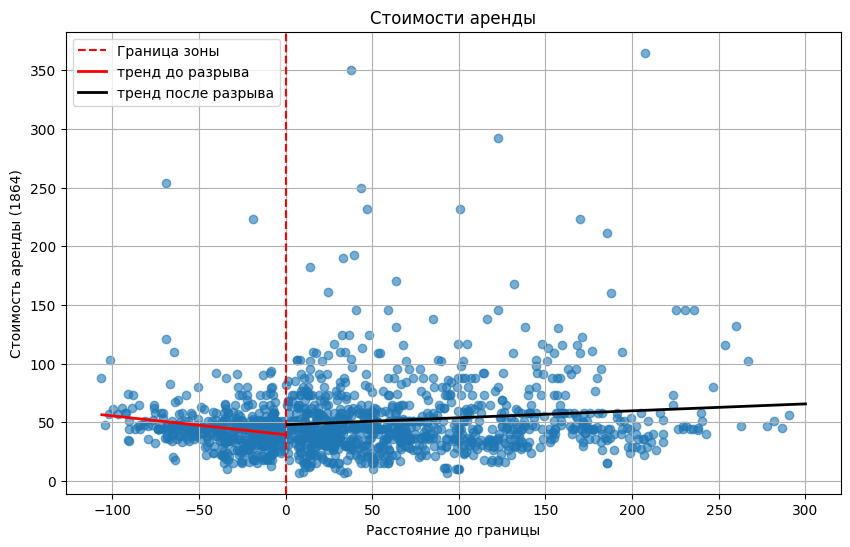

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(df['running'], df['rentals_64'], alpha=0.6)
plt.axvline(0, color='red', linestyle='--', label='Граница зоны')
plt.title("Cтоимости аренды")
plt.xlabel("Расстояние до границы")
plt.ylabel("Стоимость аренды (1864)")

m01 = smf.ols(formula='rentals_64~running', data=df[df['running']<=0][['rentals_64','running']].dropna()).fit()
x1 = np.linspace(-106, 0, 106)
a = m01.params['running']
b = m01.params['Intercept']
y1 = a * x1 + b
plt.plot(x1, y1, label='тренд до разрыва',color='red', linewidth=2.0)

m02 = smf.ols(formula='rentals_64~running', data=df[df['running']>=0][['rentals_64','running']].dropna()).fit()
x2 = np.linspace(1, 300, 299)
a = m02.params['running']
b = m02.params['Intercept']
y2 = a * x2 + b
plt.plot(x2, y2, label='тренд после разрыва',color='black', linewidth=2.0)

plt.legend()
plt.grid()
plt.show()

### Ядерная оценка 

In [8]:
# Треугольное ядро
data = df[['rentals_64','running']].dropna()
triangular_results = rdrobust(data['rentals_64'], data['running'], kernel='triangular')
print(triangular_results)


Call: rdrobust
Number of Observations:                  1357
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           435        922
Number of Unique Obs.            434        900
Number of Effective Obs.         180        169
Bandwidth Estimation           21.23      21.23
Bandwidth Bias                36.661     36.661
rho (h/b)                      0.579      0.579

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional      13.155    4.673    2.815   4.877e-03    [3.996, 22.313]
Robust                 -        -    2.649   8.084e-03    [3.847, 25.744]



In [9]:
# Ядро Епанечникова
epanechnikov_results = rdrobust(data['rentals_64'], data['running'], kernel='epanechnikov')
print(epanechnikov_results)

Call: rdrobust
Number of Observations:                  1357
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                          Epanechnikov
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           435        922
Number of Unique Obs.            434        900
Number of Effective Obs.         173        159
Bandwidth Estimation          19.722     19.722
Bandwidth Bias                35.584     35.584
rho (h/b)                      0.554      0.554

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional      12.755    4.725    2.699   6.948e-03    [3.494, 22.017]
Robust                 -        -    2.525   1.157e-02    [3.193, 25.345]



In [10]:
# Прямоугольное ядро
rectangular_results = rdrobust(data['rentals_64'], data['running'], kernel='uniform')
print(rectangular_results)

Call: rdrobust
Number of Observations:                  1357
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                               Uniform
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           435        922
Number of Unique Obs.            434        900
Number of Effective Obs.         214        213
Bandwidth Estimation          25.348     25.348
Bandwidth Bias                50.418     50.418
rho (h/b)                      0.503      0.503

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       9.393    4.156     2.26   2.383e-02    [1.246, 17.539]
Robust                 -        -    2.055   3.990e-02    [0.464, 19.621]



## Оценка долгосрочного эффекта

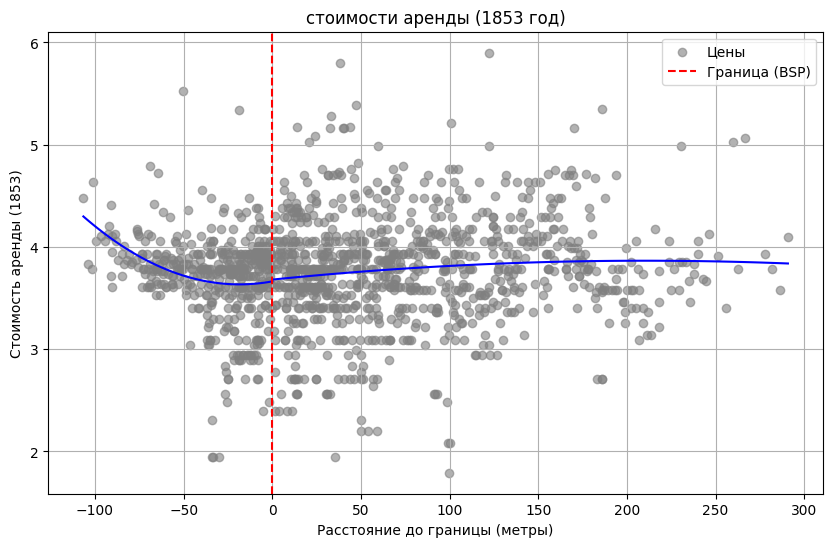

In [12]:
data = df.copy()
data['running_variable'] = np.where(data['broad']==1,-data['dist_netw'],data['dist_netw'])  
data = data.dropna(subset=['log_rentals_1853', 'running_variable'])  


left_data = data[data['running_variable'] <= 0]
right_data = data[data['running_variable'] > 0]

left_model = smf.ols('log_rentals_1853 ~ running_variable + I(running_variable ** 2)', data=left_data).fit()
right_model = smf.ols('log_rentals_1853 ~ running_variable + I(running_variable ** 2)', data=right_data).fit()

x_left = np.linspace(left_data['running_variable'].min(), 0, 100)
x_right = np.linspace(0, right_data['running_variable'].max(), 100)
y_left = left_model.predict(pd.DataFrame({'running_variable': x_left, 'I(running_variable ** 2)': x_left**2}))
y_right = right_model.predict(pd.DataFrame({'running_variable': x_right, 'I(running_variable ** 2)': x_right**2}))


plt.figure(figsize=(10, 6))
plt.scatter(data['running_variable'], data['log_rentals_1853'], alpha=0.6, label="Цены", color='gray')
plt.plot(x_left, y_left, color='blue')
plt.plot(x_right, y_right, color='blue')
plt.axvline(0, color='red', linestyle='--', label='Граница (BSP)')
plt.title("стоимости аренды (1853 год)")
plt.xlabel("Расстояние до границы (метры)")
plt.ylabel("Стоимость аренды (1853)")
plt.legend()
plt.grid()
plt.show()

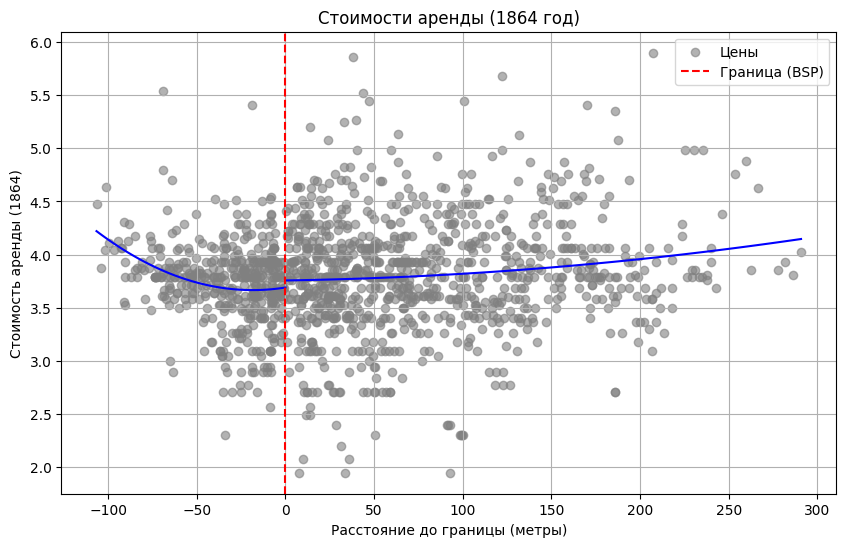

In [112]:
data = df.copy()
data['running_variable'] = np.where(data['broad']==1,-data['dist_netw'],data['dist_netw'])  
data = data.dropna(subset=['log_rentals_1864', 'running_variable'])  


left_data = data[data['running_variable'] <= 0]
right_data = data[data['running_variable'] > 0]


left_model = smf.ols('log_rentals_1864 ~ running_variable + I(running_variable ** 2)', data=left_data).fit()
right_model = smf.ols('log_rentals_1864 ~ running_variable + I(running_variable ** 2)', data=right_data).fit()

x_left = np.linspace(left_data['running_variable'].min(), 0, 100)
x_right = np.linspace(0, right_data['running_variable'].max(), 100)
y_left = left_model.predict(pd.DataFrame({'running_variable': x_left, 'I(running_variable ** 2)': x_left**2}))
y_right = right_model.predict(pd.DataFrame({'running_variable': x_right, 'I(running_variable ** 2)': x_right**2}))


plt.figure(figsize=(10, 6))
plt.scatter(data['running_variable'], data['log_rentals_1864'], alpha=0.6, label="Цены", color='gray')
plt.plot(x_left, y_left, color='blue')
plt.plot(x_right, y_right, color='blue')
plt.axvline(0, color='red', linestyle='--', label='Граница (BSP)')
plt.title("Стоимости аренды (1864 год)")
plt.xlabel("Расстояние до границы (метры)")
plt.ylabel("Стоимость аренды (1864)")
plt.legend()
plt.grid()
plt.show()

### Проверка с помощью ложных границ

In [118]:
# Создадим 3 ложные границы на разных участках 
false_boundaries = np.percentile(data['running_variable'], [25, 50, 75])
display(false_boundaries)
results = {}
for boundary in false_boundaries:
    data['false'] = (data['running_variable'] >= boundary).astype(int)
    
    model = smf.ols('log_rentals_1864 ~ running_variable + false', data=data).fit()
    results[boundary] = {
        'Ложная граница': boundary,
        'Коэфицент': model.params['false'],
        'p_value': model.pvalues['false'],
    }
results = pd.DataFrame(results).T
results

array([-10.636891,  28.945753,  91.78046 ])

,Ложная граница,Коэфицент,p_value
-10.636891,-10.636891,-0.038102,0.348835
28.945753,28.945753,0.040673,0.351978
91.780460,91.780460,0.041256,0.440276
